In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import plotly.io as pio
from sklearn.neighbors import KernelDensity

import io
from PIL import Image
from skimage.filters import threshold_mean, threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops_table, label
from skimage.color import label2rgb
from scipy import optimize
from scipy.spatial import ConvexHull

%config InlineBackend.figure_format = 'retina' 

### 0. Helper functions

In [525]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf).convert("L")
    return img

# From the Scipy cookbook

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [2]:
df = pd.read_csv('../data/spk_trancation_detail_res.csv', index_col=[0])#.sample(2000000)
df_actor = pd.read_csv('../data/actor_balances.csv', index_col=[0])
df = df.merge(df_actor, left_on='from_id', right_on='id')
df = df[['from_id', 'to_id', 'value', 'balance']]
df['balance'] = (pd.to_numeric(df['balance'], errors='coerce')*1e-18).fillna(0)
del df_actor

In [3]:
edgelist = df[['from_id', 'to_id', 'value']]
G = nx.from_pandas_edgelist(edgelist, 'from_id', 'to_id', 'value', create_using=nx.DiGraph)
print("Populated network")
num_neighs = {g[0]:len(g[1]) for g in G.adjacency()}
print('1 of 6 / Calculated number of neighbors')
centrality = nx.degree_centrality(G)
print('2 of 6 / Calculated centrality')
in_centrality = nx.in_degree_centrality(G)
print('3 of 6 / Calculated in-centrality')
out_centrality = nx.out_degree_centrality(G)
print('4 of 6 / Calculated out-centrality')
avg_neigh_degree = nx.average_neighbor_degree(G)
print('5 of 6 / Calculated neighbor degree')
pagerank = nx.pagerank(G)
print('6 of 6 / PageRank')

Populated network
1 of 6 / Calculated number of neighbors
2 of 6 / Calculated centrality
3 of 6 / Calculated in-centrality
4 of 6 / Calculated out-centrality
5 of 6 / Calculated neighbor degree
6 of 6 / PageRank


In [4]:
df_num_neighs = pd.DataFrame.from_dict(num_neighs, orient='index', columns=['num_neighs'])
df_centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality'])
df_in_centrality = pd.DataFrame.from_dict(in_centrality, orient='index', columns=['in_centrality'])
df_out_centrality = pd.DataFrame.from_dict(out_centrality, orient='index', columns=['out_centrality'])
df_avg_neigh_degree = pd.DataFrame.from_dict(avg_neigh_degree, orient='index', columns=['avg_neigh_degree'])
df_pagerank = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])

dataframe = df_num_neighs\
    .merge(df_centrality, left_index=True, right_index=True)\
    .merge(df_in_centrality, left_index=True, right_index=True)\
    .merge(df_out_centrality, left_index=True, right_index=True)\
    .merge(df_avg_neigh_degree, left_index=True, right_index=True)\
    .merge(df_pagerank, left_index=True, right_index=True)

dataframe = dataframe.join(df.groupby('from_id').sum()['value'], how='left').fillna(0)
dataframe.rename(columns={'value': 'value_spent'}, inplace=True)
dataframe = dataframe.join(df.groupby('to_id').sum()['value'], how='left').fillna(0)    
dataframe.rename(columns={'value': 'value_received'}, inplace=True)
dataframe = dataframe.join(df.groupby('from_id').sum()['balance'], how='left').fillna(0)    
dataframe.rename(columns={'value': 'balance'}, inplace=True)

pipeline = make_pipeline(PowerTransformer(), StandardScaler(), PCA(n_components=2))
pipeline.fit(dataframe[dataframe.columns[0:-1]])
data_pc = pipeline.transform(dataframe[dataframe.columns[0:-1]])

In [6]:
exchange_nodes = ['f036150', #bitfinex
                   'f084877', 'f0227189', 'f0227195', # coinbase
                   'f034689', #gate
                   'f033259', #huobi
                   'f033544', #kraken
                   'f042593',  #kucoin
                   'f047684',  #oke
                   'f0412624', 'f039682', 'f023933', 'f033348', 'f0130039', 'f099824'
                  ]
dfc = dataframe.loc[exchange_nodes]
dx = pipeline.transform(dfc[dfc.columns[0:-1]])

No handles with labels found to put in legend.


Text(0.5, 1.0, '1000000 selected nodes')

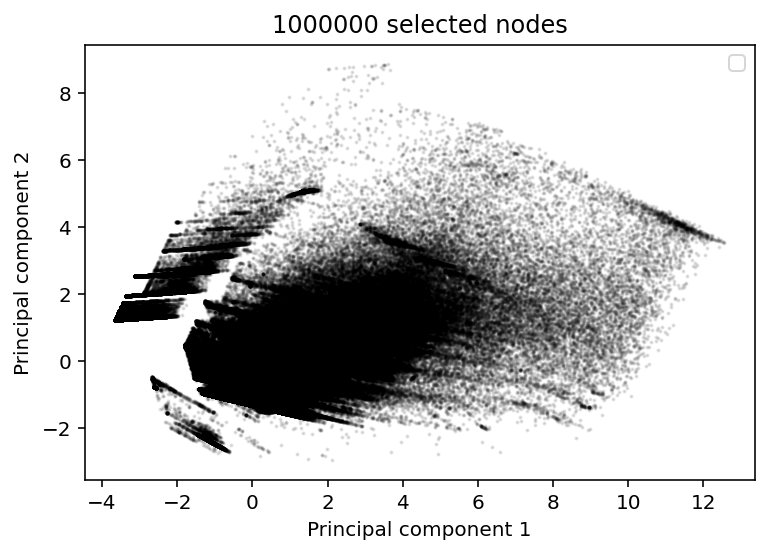

In [58]:
n_points = 1000000
select_idx = np.random.choice(data_pc.shape[0], size=n_points, replace=False)
plt.plot(data_pc[select_idx][:,0], data_pc[select_idx][:,1], 'o', ms=1, c='k', alpha=0.1)
# plt.plot(dx[:,0], dx[:,1], 'o', label='Exchange')
plt.legend(loc='best')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('%i selected nodes' % len(select_idx))

### Strategy

1. Transform the transactional network into PCA space.
2. Calculate a *discrete* density plot with a 2D histogram.
3. Convert this plot into a binary image.
4. Perform thresholding and remove small points.
5. What remains are individual clusters.
6. Triangulate all points that lie within the individual clusters.
7. Extract the convex hull of each cluster. This will be considered the cluster for fitting.
8. Filter the original dataset.
9. Perform a 2D Gaussian fit to each cluster. (Only points in the convex hull of each cluster are considered for the fitting.)

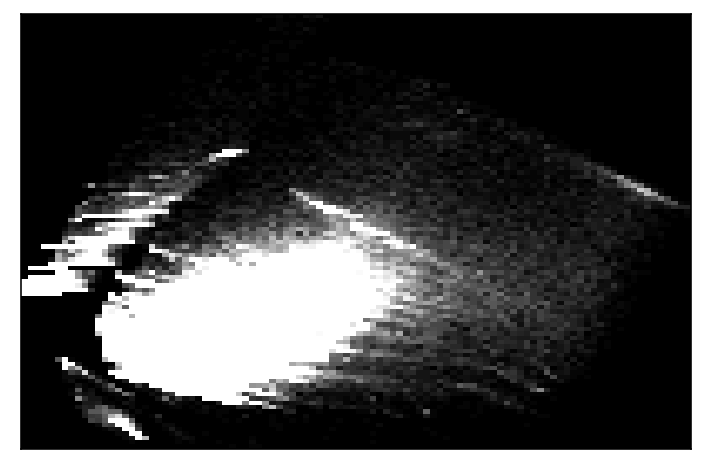

In [241]:
Z, xedges, yedges = np.histogram2d(data_pc[select_idx][:,0], data_pc[select_idx][:,1], bins=100)
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, Z.T, cmap='gray')
pcm.set_clim(vmin=0, vmax=50)
ax.margins(x=0, y=0)
ax.set_xticks([]);
ax.set_yticks([]);

img = np.array(fig2img(fig))
img = img[54:-54, 54:-54]
img_thresh = img > threshold_mean(img)
img_change = remove_small_objects(img_thresh,1)

Text(0.5, 1.0, 'Remove small objects')

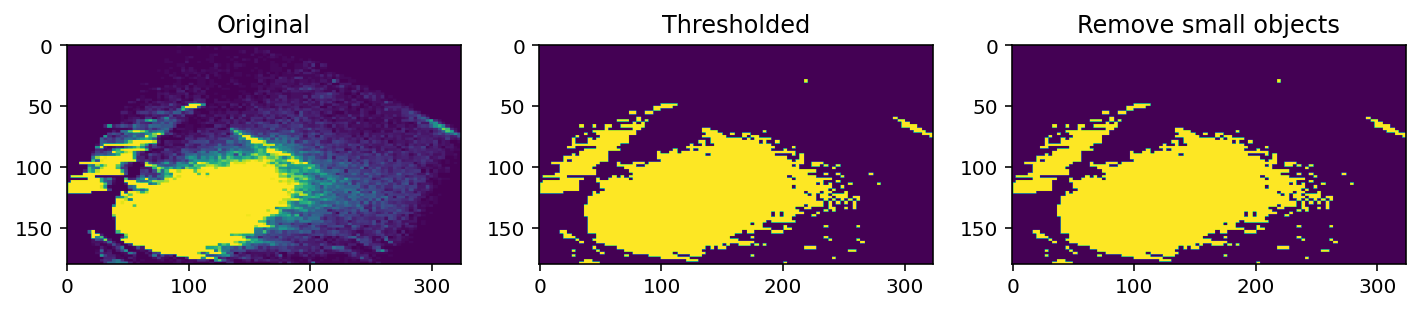

In [257]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))
ax1.imshow(img.astype(int))
ax2.imshow(img_thresh.astype(int))
ax3.imshow(img_change.astype(int))
ax1.set_title('Original')
ax2.set_title('Thresholded')
ax3.set_title('Remove small objects')

In [334]:
label_image = label(np.flipud(img > threshold_mean(img)), connectivity=img_change.ndim)
rp = regionprops_table(label_image, np.flipud(img_change.astype(int)), properties=['area', 'centroid', 'extent'])
rp_df = pd.DataFrame(rp)
rp_df['centroid_pca_x'] = rp_df['centroid-1'] / img.shape[-1] * (xedges[-1] - xedges[0]) + xedges[0]
rp_df['centroid_pca_y'] = rp_df['centroid-0']/ img.shape[0] * (yedges[-1] - yedges[0]) + yedges[0]

Text(0, 0.5, 'Principal component 2')

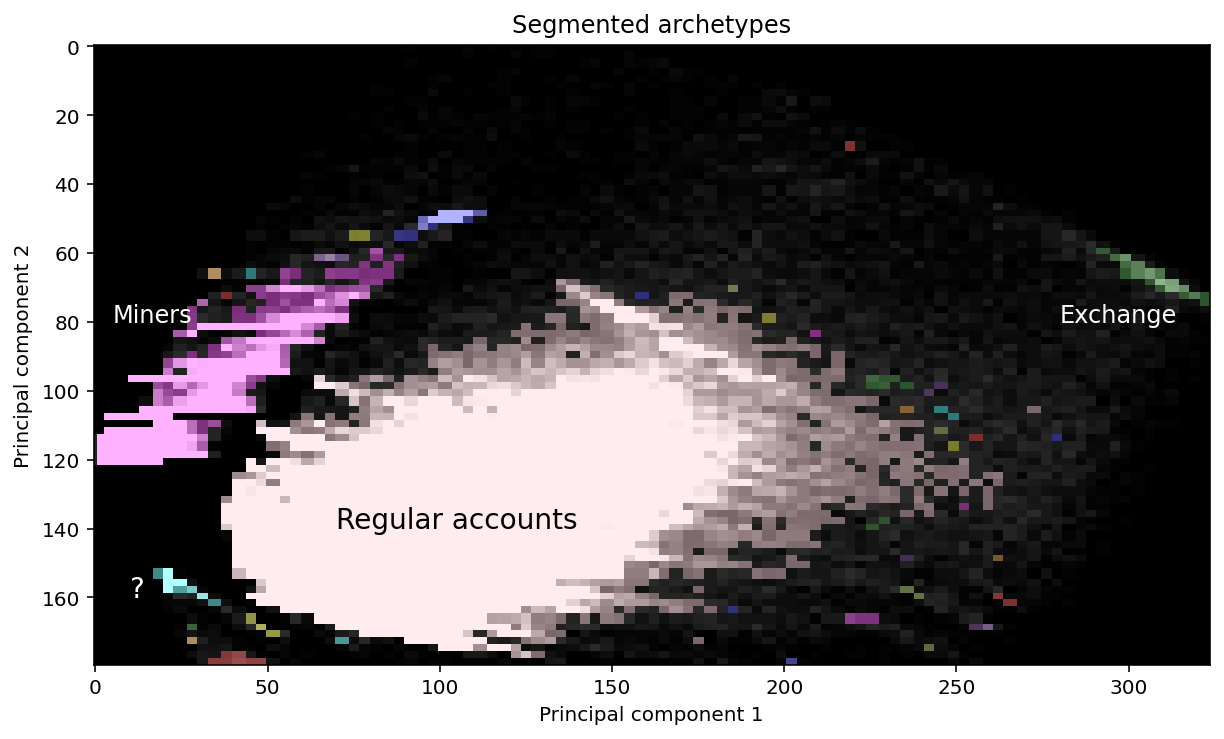

In [499]:
label_image_unflipped = label(img > threshold_mean(img), connectivity=img_change.ndim)
image_label_overlay = label2rgb(label_image_unflipped, image=img, bg_label=0)
coordinates_of_cluster = lambda n: np.argwhere(label_image == n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
ax.set_title('Segmented archetypes')
ax.text(5,80, 'Miners', color='white', fontsize=12)
ax.text(10,160, '?', color='white', fontsize=14)
ax.text(70, 140, 'Regular accounts', color='black', fontsize=14)
ax.text(280,80, 'Exchange', color='white', fontsize=12)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0.5, 1.0, 'Identified clusters')

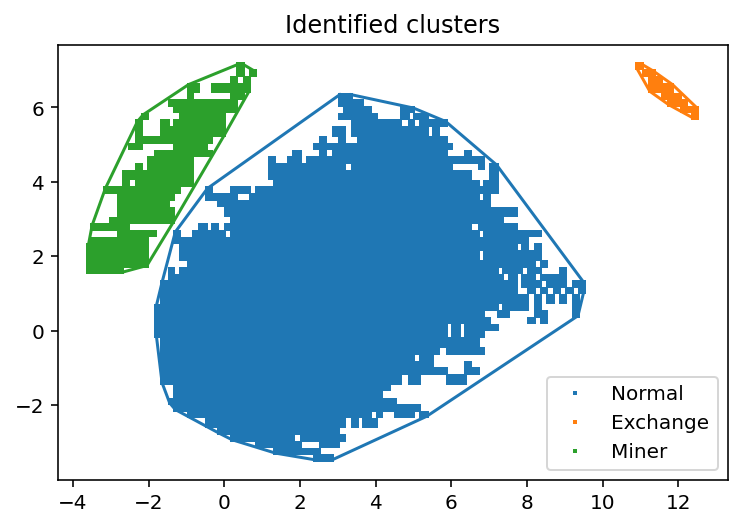

In [574]:
exchange_idx = 33 #np.argmax(rp_df.centroid_pca_x.values)
miner_idx = 21
normal_idx = 3

colorlist = ['C0', 'C1', 'C2']
cluster_list = [normal_idx,exchange_idx, miner_idx]
cluster_label = ['Normal', 'Exchange', 'Miner']
normal_pointlist = []
exchange_pointlist = []
miner_pointlist = []
point_masterlist = [normal_pointlist, exchange_pointlist, miner_pointlist]

# normal_hulllist = []
# exchange_hulllist = []
# miner_hulllist = []
# hull_masterlist = [normal_hulllist, exchange_hulllist, miner_hulllist]

hull_masterlist = []

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
fig, ax1 = plt.subplots()

for cluster_id, cluster_label, pointlist, col in zip(cluster_list, cluster_label, point_masterlist, colorlist):
    coordinates_exchange = coordinates_of_cluster(cluster_id)

    pce_out = []
    for pce in coordinates_exchange:
        pc1 = pce[1] / img.shape[-1] * (xedges[-1] - xedges[0]) + xedges[0]
        pc2 = pce[0] / img.shape[0] * (xedges[-1] - xedges[0]) + xedges[0]
        pce_out.append([pc1, pc2])
        pointlist.append([pc1, pc2])
    pce_out = np.array(pce_out)
    pointlist = np.array(pointlist)
    
    ax1.plot(pce_out[:,0], pce_out[:,1], 's', ms=1, label=cluster_label, c=col)

    hull = ConvexHull(pointlist)
    pointlist = np.array(pointlist)
    hullarray = np.array(pointlist)[hull.vertices,:]
#     hulllist = hullarray
    hull_masterlist.append(hullarray)
    ax1.plot(hullarray[:,0], hullarray[:,1], '-', c=col)    
    
ax1.legend(loc='best')    
ax1.set_title('Identified clusters')

